### Modeling Water Quality of the Potomac River
#### Predicting Total Phosphorus Levels 

**Imports**

In [1]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns

# code modified from Mike Blow's RandomForestRegressor model

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [3]:
np.random.seed(20200908)

In [4]:
water = pd.read_csv('./data/WQ_FINAL_with_Parameters.csv')

In [5]:
cols = water.columns
params = [col for col in cols if 'Parameter' in col]

**Transform Variables**

In [6]:
# create dummy variables for HUC12_
water = pd.get_dummies(water, columns=['HUC12_'], prefix='huc12', drop_first=True)

In [7]:
# create dummy variables for TideStage
water = pd.get_dummies(water, columns=['TideStage'], prefix='tide', drop_first=True)

In [8]:
# create dummy variables for SampleId
water = pd.get_dummies(water, columns=['SampleId'], prefix='sample')

In [9]:
# transform Date_Time into datetime object
water['Date_Time'] = pd.to_datetime(water['Date_Time'])

In [10]:
water['Date_Time'].dtype

dtype('<M8[ns]')

In [11]:
# create variables for year and for month
water['Years'] = water['Date_Time'].dt.year
water['Months'] = water['Date_Time'].dt.month

**Correlation Matrix**

In [12]:
water.columns[85:]

Index(['sample_2212.0', 'sample_2213.0', 'sample_2218.0', 'sample_2221.0',
       'sample_2222.0', 'sample_2294.0', 'sample_2355.0', 'sample_2363.0',
       'sample_2379.0', 'sample_2403.0',
       ...
       'sample_461663.0', 'sample_461664.0', 'sample_461665.0',
       'sample_461666.0', 'sample_461667.0', 'sample_461668.0',
       'sample_461669.0', 'sample_462091.0', 'Years', 'Months'],
      dtype='object', length=7492)

In [13]:
cols = water.columns
sample_variables = [col for col in cols if 'sample' in col]

In [14]:
huc_variables = [col for col in cols if 'huc' in col]

In [15]:
# variables to correlate with Parameter_TP

water_corr = water.drop(columns=['Agency', 'Cruise', 'Database', 'HUC12',
             'Latitude', 'Layer', 'Longitude', 'Method',
             'Program', 'Project', 'SampleReplicateType', 'SampleType',
             'Source', 'Station', 'TierLevel', 'Unit', 'Point',
             'HUCNAME_', 'FIPS_', 'COUNTY_', 'STATE_', 'TotalDepth'
            ])

In [16]:
water_corr = water_corr.drop(columns=sample_variables)

In [17]:
water_corr.drop(columns=huc_variables, inplace=True)

In [18]:
water_corr.shape

(29774, 23)

In [19]:
# correlation matrix
water_corr.corr()

,SampleDepth,Parameter_CHLA,Parameter_DO,Parameter_NH4F,Parameter_NO3F,Parameter_PH,Parameter_PO4F,Parameter_SALINITY,Parameter_SECCHI,Parameter_TALK,...,Parameter_TN,Parameter_TP,Parameter_TSS,Parameter_TURB_NTU,Parameter_WTEMP,tide_Flood Tide,tide_High Slack Tide,tide_Low Slack Tide,Years,Months
SampleDepth,1.000000,-0.051237,-0.246909,0.010671,-0.139905,0.047496,-0.031205,0.412746,-0.289386,-0.159774,...,-0.095798,0.013467,0.020906,0.009164,-0.002560,-0.126211,-0.011693,-0.035440,0.088154,-0.021554
Parameter_CHLA,-0.051237,1.000000,0.060347,0.086285,0.105260,0.018954,0.123710,-0.093204,0.155105,0.179365,...,0.296343,0.312077,0.192736,0.137265,0.052292,-0.035137,0.041375,0.010280,0.018863,-0.051131
Parameter_DO,-0.246909,0.060347,1.000000,0.016819,0.296525,0.349397,-0.025177,-0.249128,0.014052,0.159605,...,0.242648,0.076246,0.089224,0.095288,-0.561552,0.071635,0.011070,0.031532,0.182693,-0.299963
Parameter_NH4F,0.010671,0.086285,0.016819,1.000000,0.388296,-0.013437,0.370214,-0.159301,0.099321,0.342386,...,0.487142,0.354084,0.211213,0.223065,-0.070302,0.036930,-0.012965,-0.011521,-0.008756,-0.047727
Parameter_NO3F,-0.139905,0.105260,0.296525,0.388296,1.000000,-0.002388,0.451571,-0.424761,0.033627,0.614674,...,0.891921,0.508278,0.317726,0.306944,-0.257763,0.182901,-0.074527,-0.046551,0.156672,-0.133189
Parameter_PH,0.047496,0.018954,0.349397,-0.013437,-0.002388,1.000000,-0.011115,0.103022,-0.105580,0.079137,...,0.009027,-0.017780,-0.011547,0.024804,0.184529,-0.013234,0.022240,0.036448,-0.001175,-0.026594
Parameter_PO4F,-0.031205,0.123710,-0.025177,0.370214,0.451571,-0.011115,1.000000,-0.194181,0.088213,0.477934,...,0.577401,0.675833,0.287533,0.261265,0.057468,0.076268,-0.077300,-0.056797,0.028388,0.112858
Parameter_SALINITY,0.412746,-0.093204,-0.249128,-0.159301,-0.424761,0.103022,-0.194181,1.000000,-0.054703,-0.435761,...,-0.352559,-0.214836,-0.169872,-0.214561,0.097536,-0.108372,-0.045898,-0.044655,-0.041905,0.115371
Parameter_SECCHI,-0.289386,0.155105,0.014052,0.099321,0.033627,-0.105580,0.088213,-0.054703,1.000000,0.173335,...,0.134846,0.097663,0.015345,0.012274,-0.013392,-0.053579,0.036573,0.077743,-0.058363,0.034233
Parameter_TALK,-0.159774,0.179365,0.159605,0.342386,0.614674,0.079137,0.477934,-0.435761,0.173335,1.000000,...,0.631867,0.438933,0.264549,0.350185,-0.083110,0.144254,-0.027602,0.013230,0.103570,0.040325


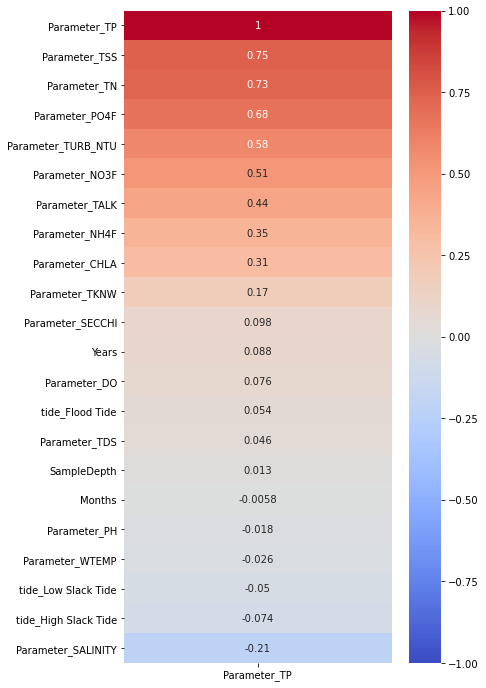

In [20]:
# heatmap to display correlation matrix
plt.figure(figsize=(6, 12))
sns.heatmap(water_corr.corr()[['Parameter_TP']].sort_values('Parameter_TP', ascending=False),
            cmap='coolwarm',
            vmin=-1,
            vmax=1,
            annot=True);
plt.show();

### Random Forest Classifier
- categorical total phosphorus as y variable

Categories:
- 0.01 - 0.03 mg/L - uncontaminated freshwater
- 0.025 - 0.1 mg/L - level at which plant growth is stimulated
- \> 0.1 mg/L - accelerated growth and consequent problems


[source](https://water-research.net/index.php/phosphates)

In [21]:
# function to create categorical total phosphorus

def categorical_TP(column):
    if column < 0.03:
        # value for uncontaminated water = 1
        value = 1
    elif column <= 0.1:
        # value for stimulated plant growth = 2
        value = 2
    elif column > 0.1:
        # value for problematic total phosphorus level = 3
        value = 3
    return value

In [22]:
# create categorical TP variable
water['Categorical_TP'] = water['Parameter_TP'].map(categorical_TP)

In [23]:
water['Categorical_TP'].isna().sum()

0

In [24]:
# columns to drop from features
col_to_drop = ['Date_Time', 'Agency', 'Cruise', 'Database', 'HUC12', 'Latitude', 'Layer', 'Longitude', 'Method', 'Program', 'Project', 
               'SampleReplicateType', 'SampleType', 'Source', 'Station', 'TierLevel', 'Unit', 'Point', 'FIPS_', 'COUNTY_', 'STATE_', 'Parameter_TP',
               'Categorical_TP', 'HUCNAME_']

In [25]:
X = water.drop(columns=col_to_drop)

y = water['Categorical_TP']

**Baseline Accuracy**

In [26]:
y.value_counts(normalize=True)

1    0.759320
2    0.209444
3    0.031235
Name: Categorical_TP, dtype: float64

**Model**

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.33,
                                                    random_state = 42,
                                                    stratify=y)

In [28]:
rf = RandomForestClassifier()

In [29]:
# parameters for grid search
params = {
    'n_estimators'      : [100, 200, 300],
    'min_samples_split' : [10, 20, 30],
    'max_depth'         : [None, 5, 10]
}

In [30]:
# Set up grid search
gs = GridSearchCV(rf, 
                  param_grid=params, 
                  return_train_score=True, 
                  cv = 5)

In [31]:
# Run grid search on training data with a time check. WARNING: this search takes ~ 8 min. with n_jobs=6
import time
t0 = time.time()
gs.fit(X_train, y_train)
print(time.time() - t0)

3342.6488819122314


# Evaluation

In [41]:
# Score on training set.
train_accuracy = gs.score(X_train, y_train)

In [42]:
# Score on testing set.
test_accuracy = gs.score(X_test, y_test)

In [43]:
# List best hyperparameters found in Grid Search
gs.best_params_

{'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200}

In [44]:
# 5-fold cross validation score.
gs.best_score_

0.9582413667661257

In [45]:
# Utilize model to get predictions on testing set.
preds = gs.predict(X_test)

In [46]:
# List scores from best features in model
gs.best_estimator_.feature_importances_

array([3.21770977e-02, 2.44038807e-02, 5.70371027e-02, ...,
       3.74101341e-05, 1.03847666e-02, 7.87703097e-03])

In [47]:
# Grab feature names, their importance, and sort them into a dataframe.
features_df = pd.DataFrame(gs.best_estimator_.feature_importances_, X_train.columns, columns=['Importance'])
features_df.sort_values(by='Importance', ascending=False).head(25)

,Importance
Parameter_PO4F,0.117009
Parameter_NO3F,0.111855
Parameter_TSS,0.106626
Parameter_TN,0.097636
Parameter_NH4F,0.091740
Parameter_TURB_NTU,0.059299
Parameter_TALK,0.057509
Parameter_CHLA,0.057037
SampleDepth,0.032177
TotalDepth,0.024404


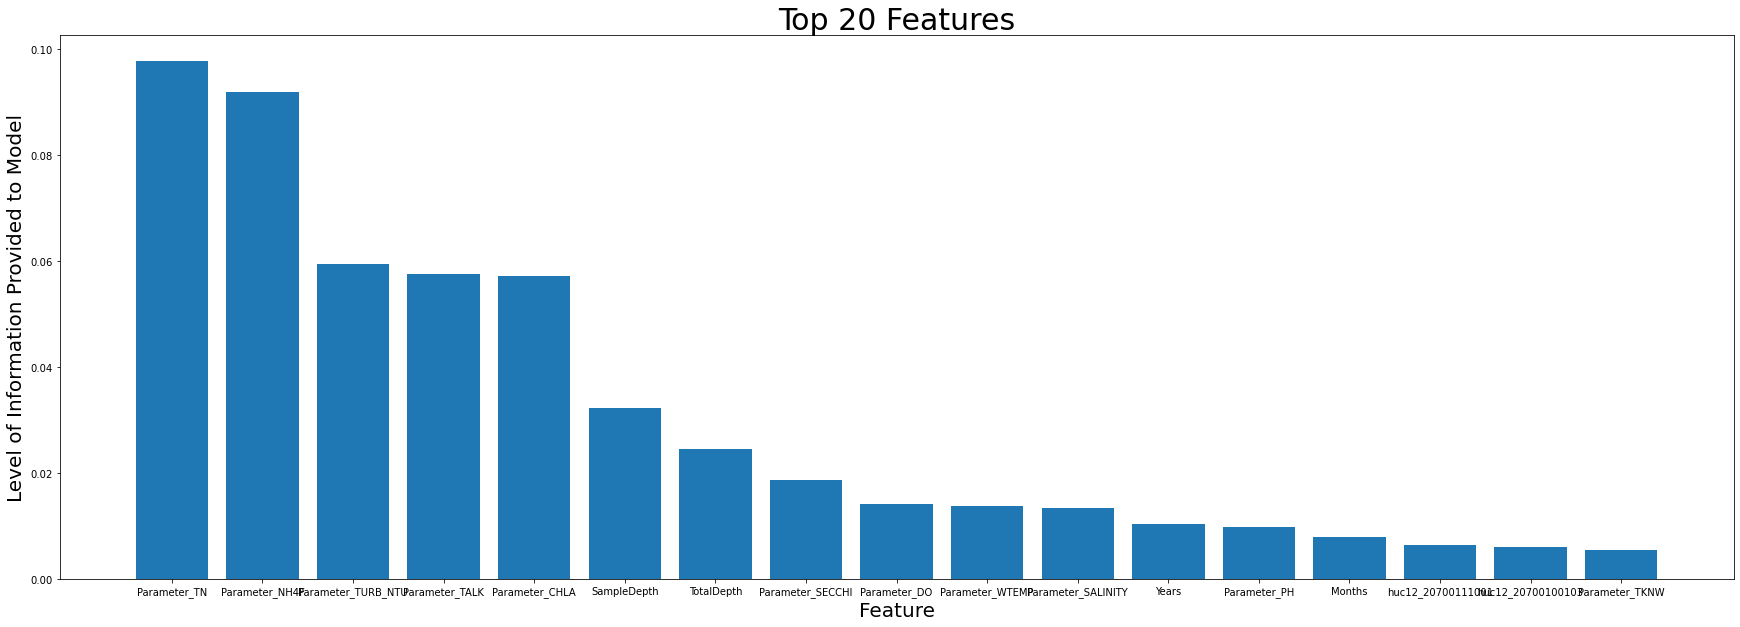

In [48]:
# plot the top features minus the top 3 ('leadership', 'leader', & 'leaders')
plt.figure(figsize=(30,10))
temp = features_df.sort_values('Importance', ascending=False).head(20)
plt.bar(temp.index[3:], temp['Importance'][3:])
plt.title('Top 20 Features', fontsize=30)
plt.xlabel('Feature', fontsize=20)
plt.ylabel('Level of Information Provided to Model', fontsize=20);

In [49]:
# print accuracy scores
print(f'Traning accuracy: {round(train_accuracy, 2)}')
print(f'Testing accuarcy: {round(test_accuracy, 2)}')
print('Cross-validated accuracy:', round(gs.best_score_, 2))

Traning accuracy: 0.99
Testing accuarcy: 0.96
Cross-validated accuracy: 0.96


The model is slightly overfit to the training data, however, the cross-validated accuracy score supports the 97% testing accuracy. The model seems to generalize well in predicting the total_phosphorus categories of healthy level, level of promoting plant growth, and alarmingly high level that may lead to rapid plant growth such as algea bloom and eutrophication.